In [32]:
# NOTE: This Jupyter Notebook was trained locally; sections of the code will not run as intended if run on Google Colab.

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models

from PIL import Image
import pandas as pd
import os
import csv
import random

In [33]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file, skip_blank_lines=True)
        self.image_folder = image_folder
        self.transform = transform
        self.image_names = self.data.iloc[:, 0].astype(str).tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.data.iloc[index, 1:-1].values.astype(float)

        num_classes = 20
        label = torch.tensor(label, dtype=torch.float32)
        one_hot = torch.zeros(num_classes, dtype=torch.float32)
        one_hot[label == 1] = 1

        return image, one_hot

In [34]:
def get_data_loader(combined_csv_file, multi_csv_file, image_folder, batch_size=100, image_size=(224, 224), normalize=True):
    transform_list = [transforms.Resize(image_size)]
    if normalize:
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #imagenet norm
        ])
    else:
        transform_list.append(transforms.ToTensor())

    transform = transforms.Compose(transform_list)

    dataset = CustomDataset(csv_file=combined_csv_file, image_folder=image_folder, transform=transform)

    # create the dimmed dataset
    dim_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ColorJitter(brightness=[0.25, 0.75]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dim_set = CustomDataset(csv_file=multi_csv_file, image_folder=image_folder, transform=dim_transform)

    # create the brightened dataset
    brighten_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ColorJitter(brightness=[1.25, 1.75]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    bright_set = CustomDataset(csv_file=multi_csv_file, image_folder=image_folder, transform=brighten_transform)

    class RandomChoiceRotation:
        def __init__(self):
            self.degrees = [90, 180]
            self.angle = None

        def __call__(self, img):
            self.angle = random.choice(self.degrees)
            return img.rotate(self.angle)

        def get_angle(self):
            return self.angle

    rotate_transform = transforms.Compose([
        transforms.Resize(image_size),
        RandomChoiceRotation(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    rot_set = CustomDataset(csv_file=multi_csv_file, image_folder=image_folder, transform=rotate_transform)

    # Combine the datasets
    dataset = dataset + dim_set + bright_set + rot_set

    train_ratio,val_ratio,test_ratio = 0.8,0.1,0.1

    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size

    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    print("Length of train_set:", len(train_set))
    print("Length of val_set:", len(val_set))
    print("Length of test_set:", len(test_set))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

    print("Length of train_loader:", len(train_loader))
    print("Length of val_loader:", len(val_loader))
    print("Length of test_loader:", len(test_loader))

    return train_loader, val_loader, test_loader

In [35]:
def get_f1_score(net, data_loader, threshold=0.5): #may need to tune threshold
    # Returns f1 score instead of accuracy since using unbalanced data set.
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Preventing gradient calculation so we don't override the actual training
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            output = net(imgs)

            # Apply the threshold to the predicted output probabilities
            predicted = (output >= threshold).float()

            # Perform one-hot encoding on the ground truth labels
            labels_one_hot = torch.zeros_like(predicted)
            labels_one_hot[labels == 1] = 1

            # Calculate true positives, false positives, and false negatives
            true_positives += ((predicted == 1) & (labels_one_hot == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels_one_hot == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels_one_hot == 1)).sum().item()

    # Addressing the edge case of model not achieving any true positives
    if true_positives == 0:
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
    else:
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

In [36]:
def get_model_name(name, batch_size, learning_rate, decay_rate, threshold, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        name: Name of the model
        batch_size: Batch size
        learning_rate: Learning rate
        epoch: Epoch number
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_dr{3}_thresh{4}_epoch{5}".format(name, batch_size, learning_rate, decay_rate, threshold, epoch)

    return path

def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        model: PyTorch neural network object
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0
    i = 0

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)  # Move the input tensors to the desired device
            labels = labels.to(device)

            labels = labels.float()
            out = model(imgs)  # forward pass
            loss = criterion(out, labels)  # compute the total loss
            total_loss += loss.item()
            i += 1

    model.train()  # Set the model back to training mode

    loss = float(total_loss) / (i + 1)
    return loss

def plot_training_curve(path):
    """Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path), delimiter=',')  # Specify delimiter as ','
    val_acc = np.loadtxt("{}_val_acc.csv".format(path), delimiter=',')  # Specify delimiter as ','

    plt.title("Train vs Validation Accuracy")
    n = len(train_acc)  # number of epochs
    plt.plot(range(1, n + 1), train_acc, label="Train")
    plt.plot(range(1, n + 1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [37]:
def train(model, combined_csv_file, multi_csv_file, image_folder, batch_size=100, num_epochs=5, learning_rate=1e-3, decay_rate=0.9, threshold=0.5):
    torch.manual_seed(1000)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader, test_loader = get_data_loader(combined_csv_file=combined_csv_file, multi_csv_file=multi_csv_file, image_folder=image_folder, batch_size=batch_size, image_size=(224,224), normalize=True)

    # Sending data to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        i = 0

        # Learning rate decay calculation
        current_learning_rate = learning_rate / (1 + decay_rate * epoch)

        # Update optimizer learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate

        for imgs, labels in train_loader:
            labels = labels.float()
            if torch.cuda.is_available():
                imgs = imgs.cuda().to(device)
                labels = labels.cuda().to(device)

            optimizer.zero_grad()

            out = model(imgs)
            loss = criterion(out, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            i += 1

        total_train_loss += loss.item()

        train_epoch_acc = get_f1_score(model, train_loader, threshold=threshold)
        train_acc.append(train_epoch_acc)

        val_epoch_acc = get_f1_score(model, val_loader, threshold=threshold)
        val_acc.append(val_epoch_acc)

        train_loss.append(total_train_loss / (i + 1))
        val_loss.append(evaluate(model, val_loader, criterion))

        try:
            print(("Epoch {}: Train Acc: {:.4f}, Train Loss: {:.4f} | " +
                   "Validation Acc: {:.4f}, Validation Loss: {:.4f}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch],
                val_acc[epoch],
                val_loss[epoch]))
        except Exception as e:
            print("An error occurred during printing:", e)

        if (epoch % 5) == 4 or epoch == 0:
            model_path = get_model_name(model.module.name, batch_size, learning_rate, decay_rate, threshold, epoch)
            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    try:
        with open("{}_train_acc.csv".format(model_path), "w", newline="") as f_train_acc:
            writer_train_acc = csv.writer(f_train_acc)
            writer_train_acc.writerow(train_acc)

        with open("{}_val_acc.csv".format(model_path), "w", newline="") as f_val_acc:
            writer_val_acc = csv.writer(f_val_acc)
            writer_val_acc.writerow(val_acc)
    except Exception as e:
        print("An error occurred while saving the results:", e)

    return test_loader

In [38]:
class BaselinePigeon(nn.Module):
    def __init__(self, num_classes):
        super(BaselinePigeon, self).__init__()
        self.name = "baselinepigeonclassifier"
        self.layer1 = nn.Linear(3 * 224 * 224, 120)
        self.layer2 = nn.Linear(120, 60)
        self.layer3 = nn.Linear(60, num_classes)
        self.sigmoid = nn.Sigmoid() # Used for binary classification

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x

In [39]:
class DenseNetMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetMultiLabel, self).__init__()
        self.name = "densenetclassifier"
        self.densenet = models.densenet121(pretrained=True)
        num_features = self.densenet.classifier.in_features
        # Attaching our classifier to the pretrained model
        self.densenet.classifier = nn.Linear(num_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.densenet(x)
        x = self.sigmoid(x)
        return x

In [40]:
class ResNetMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetMultiLabel, self).__init__()
        self.num_classes = num_classes
        self.name = "resnetclassifier"

        # Load the pre-trained ResNet model
        resnet = models.resnet50(pretrained=True)

        # Replace the last fully connected layer
        num_features = resnet.fc.in_features
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Use sigmoid activation for multi-label classification
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [41]:
num_classes = 20
combined_csv_file = r"C:\Users\ricky\PycharmProjects\aps360\Dataset Label - Sheet3 Combined.csv"
multi_csv_file = r"C:\Users\ricky\PycharmProjects\aps360\Dataset Label - Sheet1 Updated.csv"
single_csv_file = r"C:\Users\ricky\PycharmProjects\aps360\Dataset Label - Sheet2.csv"
image_folder = r"C:\Users\ricky\PycharmProjects\aps360\Combined Fruit Dataset"

In [42]:
use_cuda = True
baselinepigeonclassifier = BaselinePigeon(num_classes)

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    baselinepigeonclassifier.cuda()
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

baselinepigeonclassifier.to(device)  # Move the model to the desired device
baselinepigeonclassifier = nn.DataParallel(baselinepigeonclassifier)

torch.cuda.empty_cache()
baselinemodel_testloader1 = train(baselinepigeonclassifier, combined_csv_file, multi_csv_file, image_folder, batch_size=150, num_epochs=10, learning_rate=1e-3, decay_rate=0.9, threshold=0.5)

CUDA is available! Training on GPU...
Length of train_set: 4800
Length of val_set: 600
Length of test_set: 600
Length of train_loader: 32
Length of val_loader: 4
Length of test_loader: 4


C:\Users\ricky\anaconda3\envs\aps360\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1: Train Acc: 0.2689, Train Loss: 0.0395 | Validation Acc: 0.2148, Validation Loss: 1.0358
Epoch 2: Train Acc: 0.3045, Train Loss: 0.0249 | Validation Acc: 0.2106, Validation Loss: 0.6609
Epoch 3: Train Acc: 0.3303, Train Loss: 0.0175 | Validation Acc: 0.2199, Validation Loss: 0.5042
Epoch 4: Train Acc: 0.3344, Train Loss: 0.0164 | Validation Acc: 0.2027, Validation Loss: 0.4481
Epoch 5: Train Acc: 0.3902, Train Loss: 0.0142 | Validation Acc: 0.2220, Validation Loss: 0.4330
Epoch 6: Train Acc: 0.4163, Train Loss: 0.0136 | Validation Acc: 0.2346, Validation Loss: 0.4157
Epoch 7: Train Acc: 0.4421, Train Loss: 0.0115 | Validation Acc: 0.2331, Validation Loss: 0.4074
Epoch 8: Train Acc: 0.4290, Train Loss: 0.0107 | Validation Acc: 0.2221, Validation Loss: 0.3938
Epoch 9: Train Acc: 0.4360, Train Loss: 0.0111 | Validation Acc: 0.2144, Validation Loss: 0.3880
Epoch 10: Train Acc: 0.4531, Train Loss: 0.0112 | Validation Acc: 0.2310, Validation Loss: 0.3774
Finished Training
Total time 

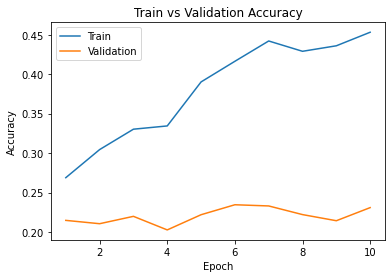

In [43]:
path_to_baselinemodel = get_model_name("baselinepigeonclassifier",batch_size=150,learning_rate=1e-3, decay_rate=0.9, threshold=0.5, epoch=9)
plot_training_curve(path_to_baselinemodel)

In [44]:
test_acc_baselinemodel = get_f1_score(baselinepigeonclassifier, baselinemodel_testloader1, threshold=0.5)
print(test_acc_baselinemodel)

0.23330887747615553


CUDA is available! Training on GPU...
Length of train_set: 4800
Length of val_set: 600
Length of test_set: 600
Length of train_loader: 32
Length of val_loader: 4
Length of test_loader: 4
Epoch 1: Train Acc: 0.4357, Train Loss: 0.0085 | Validation Acc: 0.4468, Validation Loss: 0.1761
Epoch 2: Train Acc: 0.6484, Train Loss: 0.0048 | Validation Acc: 0.6019, Validation Loss: 0.1344
Epoch 3: Train Acc: 0.7590, Train Loss: 0.0035 | Validation Acc: 0.6843, Validation Loss: 0.1033
Epoch 4: Train Acc: 0.8574, Train Loss: 0.0028 | Validation Acc: 0.7751, Validation Loss: 0.0840
Epoch 5: Train Acc: 0.9085, Train Loss: 0.0023 | Validation Acc: 0.8200, Validation Loss: 0.0693
Epoch 6: Train Acc: 0.9404, Train Loss: 0.0015 | Validation Acc: 0.8652, Validation Loss: 0.0615
Epoch 7: Train Acc: 0.9637, Train Loss: 0.0010 | Validation Acc: 0.8750, Validation Loss: 0.0553
Epoch 8: Train Acc: 0.9760, Train Loss: 0.0009 | Validation Acc: 0.8955, Validation Loss: 0.0517
Epoch 9: Train Acc: 0.9829, Train Los

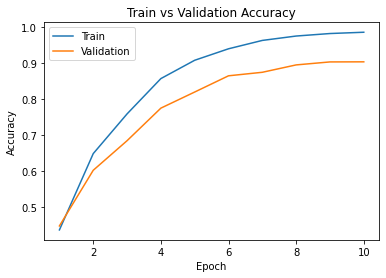

The final test accuracy of our model is: 88.11963445029079 %


In [48]:
use_cuda = True
densenetclassifier = DenseNetMultiLabel(num_classes)

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    densenetclassifier.cuda()
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

densenetclassifier.to(device)  # Move the model to the desired device
densenetclassifier = nn.DataParallel(densenetclassifier)

torch.cuda.empty_cache()
densenet_testloader2 = train(densenetclassifier, combined_csv_file, multi_csv_file, image_folder, batch_size=150, num_epochs=10, learning_rate=1e-3, decay_rate=0.9, threshold=0.75)

path_to_densenet2 = get_model_name("densenetclassifier",batch_size=150,learning_rate=1e-3, decay_rate=0.9, threshold=0.75, epoch=9)
plot_training_curve(path_to_densenet2)

test_accuracy = get_f1_score(densenetclassifier, densenet_testloader2, threshold=0.75)
print("The final test accuracy of our model is:", test_accuracy*100,"%")

CUDA is available! Training on GPU...
Length of train_set: 4800
Length of val_set: 600
Length of test_set: 600
Length of train_loader: 32
Length of val_loader: 4
Length of test_loader: 4


C:\Users\ricky\anaconda3\envs\aps360\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1: Train Acc: 0.5784, Train Loss: 0.0094 | Validation Acc: 0.5712, Validation Loss: 0.1989
Epoch 2: Train Acc: 0.7334, Train Loss: 0.0061 | Validation Acc: 0.6925, Validation Loss: 0.1619
Epoch 3: Train Acc: 0.8101, Train Loss: 0.0045 | Validation Acc: 0.7475, Validation Loss: 0.1303
Epoch 4: Train Acc: 0.8962, Train Loss: 0.0037 | Validation Acc: 0.8269, Validation Loss: 0.1036
Epoch 5: Train Acc: 0.9398, Train Loss: 0.0029 | Validation Acc: 0.8636, Validation Loss: 0.0833
Epoch 6: Train Acc: 0.9683, Train Loss: 0.0018 | Validation Acc: 0.8965, Validation Loss: 0.0673
Epoch 7: Train Acc: 0.9834, Train Loss: 0.0010 | Validation Acc: 0.9096, Validation Loss: 0.0608
Epoch 8: Train Acc: 0.9905, Train Loss: 0.0010 | Validation Acc: 0.9185, Validation Loss: 0.0542
Epoch 9: Train Acc: 0.9935, Train Loss: 0.0007 | Validation Acc: 0.9329, Validation Loss: 0.0496
Epoch 10: Train Acc: 0.9952, Train Loss: 0.0006 | Validation Acc: 0.9347, Validation Loss: 0.0470
Finished Training
Total time 

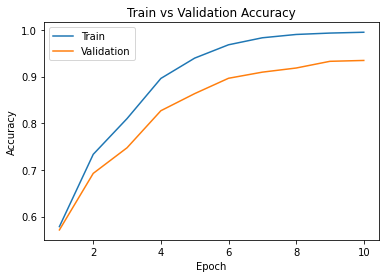

The final test accuracy of our model is: 90.6258114775383 %


In [49]:
use_cuda = True
densenetclassifier = DenseNetMultiLabel(num_classes)

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    densenetclassifier.cuda()
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

densenetclassifier.to(device)  # Move the model to the desired device
densenetclassifier = nn.DataParallel(densenetclassifier)

torch.cuda.empty_cache()
densenet_testloader3 = train(densenetclassifier, combined_csv_file, multi_csv_file, image_folder, batch_size=150, num_epochs=10, learning_rate=2e-3, decay_rate=1, threshold=0.5)

path_to_densenet3 = get_model_name("densenetclassifier",batch_size=150,learning_rate=2e-3, decay_rate=1, threshold=0.5, epoch=9)
plot_training_curve(path_to_densenet3)

test_accuracy3 = get_f1_score(densenetclassifier, densenet_testloader3, threshold=0.5)
print("The final test accuracy of our model is:", test_accuracy3*100,"%")

In [11]:
use_cuda = True
densenetclassifier = DenseNetMultiLabel(num_classes)

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    densenetclassifier.cuda()
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

densenetclassifier.to(device)  # Move the model to the desired device
densenetclassifier = nn.DataParallel(densenetclassifier)

torch.cuda.empty_cache()
densenet_testloader1 = train(densenetclassifier, combined_csv_file, multi_csv_file, image_folder, batch_size=150, num_epochs=10, learning_rate=1e-3, decay_rate=0.9, threshold=0.5)

CUDA is available! Training on GPU...
Length of train_set: 4800
Length of val_set: 600
Length of test_set: 600
Length of train_loader: 32
Length of val_loader: 4
Length of test_loader: 4


C:\Users\ricky\anaconda3\envs\aps360\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1: Train Acc: 0.6730, Train Loss: 0.0084 | Validation Acc: 0.6603, Validation Loss: 0.1785
Epoch 2: Train Acc: 0.8117, Train Loss: 0.0051 | Validation Acc: 0.7555, Validation Loss: 0.1349
Epoch 3: Train Acc: 0.8911, Train Loss: 0.0036 | Validation Acc: 0.8151, Validation Loss: 0.1043
Epoch 4: Train Acc: 0.9506, Train Loss: 0.0028 | Validation Acc: 0.8794, Validation Loss: 0.0828
Epoch 5: Train Acc: 0.9716, Train Loss: 0.0022 | Validation Acc: 0.9092, Validation Loss: 0.0700
Epoch 6: Train Acc: 0.9843, Train Loss: 0.0015 | Validation Acc: 0.9179, Validation Loss: 0.0619
Epoch 7: Train Acc: 0.9917, Train Loss: 0.0009 | Validation Acc: 0.9308, Validation Loss: 0.0566
Epoch 8: Train Acc: 0.9947, Train Loss: 0.0009 | Validation Acc: 0.9361, Validation Loss: 0.0524
Epoch 9: Train Acc: 0.9967, Train Loss: 0.0007 | Validation Acc: 0.9369, Validation Loss: 0.0488
Epoch 10: Train Acc: 0.9972, Train Loss: 0.0006 | Validation Acc: 0.9331, Validation Loss: 0.0479
Finished Training
Total time 

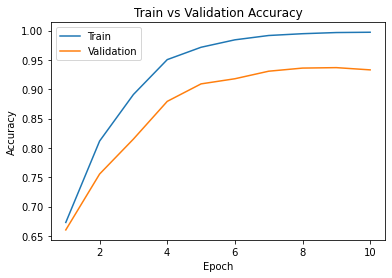

In [12]:
path_to_densenet = get_model_name("densenetclassifier",batch_size=150,learning_rate=1e-3, decay_rate=0.9, threshold=0.5, epoch=9)
plot_training_curve(path_to_densenet)

In [ ]:
use_cuda = True
resnetclassifier = ResNetMultiLabel(num_classes)

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    resnetclassifier.cuda()
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

resnetclassifier.to(device)  # Move the model to the desired device
resnetclassifier = nn.DataParallel(resnetclassifier)

torch.cuda.empty_cache()
resnet_testloader1 = train(resnetclassifier, combined_csv_file, multi_csv_file, image_folder, batch_size=150, num_epochs=10, learning_rate=1e-3, decay_rate=0.9, threshold=0.5)

CUDA is available! Training on GPU...
Length of train_set: 4800
Length of val_set: 600
Length of test_set: 600
Length of train_loader: 32
Length of val_loader: 4
Length of test_loader: 4


C:\Users\ricky\anaconda3\envs\aps360\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1: Train Acc: 0.6329, Train Loss: 0.0091 | Validation Acc: 0.6207, Validation Loss: 0.1921
Epoch 2: Train Acc: 0.7762, Train Loss: 0.0056 | Validation Acc: 0.7211, Validation Loss: 0.1452
Epoch 3: Train Acc: 0.8650, Train Loss: 0.0037 | Validation Acc: 0.7809, Validation Loss: 0.1156
Epoch 4: Train Acc: 0.9312, Train Loss: 0.0029 | Validation Acc: 0.8541, Validation Loss: 0.0893
Epoch 5: Train Acc: 0.9622, Train Loss: 0.0021 | Validation Acc: 0.8869, Validation Loss: 0.0721
Epoch 6: Train Acc: 0.9799, Train Loss: 0.0012 | Validation Acc: 0.9089, Validation Loss: 0.0622
Epoch 7: Train Acc: 0.9894, Train Loss: 0.0006 | Validation Acc: 0.9141, Validation Loss: 0.0560
Epoch 8: Train Acc: 0.9939, Train Loss: 0.0007 | Validation Acc: 0.9279, Validation Loss: 0.0517
Epoch 9: Train Acc: 0.9959, Train Loss: 0.0004 | Validation Acc: 0.9295, Validation Loss: 0.0477


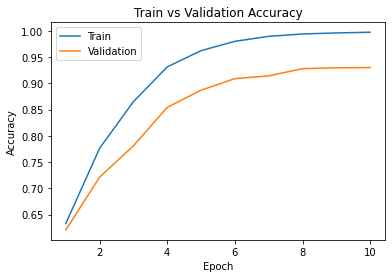

In [142]:
path_to_resnet = get_model_name("resnetclassifier",batch_size=150,learning_rate=1e-3, decay_rate=0.9, threshold=0.5, epoch=9)
plot_training_curve(path_to_resnet)

In [11]:
final_model = DenseNetMultiLabel(num_classes=20)

# Load the state_dict of the model
model_path = get_model_name("densenetclassifier", batch_size=150, learning_rate=1e-3, decay_rate=0.9, threshold=0.5, epoch=9)
state = torch.load(model_path, map_location=torch.device('cuda'))

# Remove the 'module' prefix from the state_dict keys
state = {k.replace('module.', ''): v for k, v in state.items()}

final_model.load_state_dict(state)

use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    final_model.cuda()
    print('CUDA is available! Training on GPU...')
else:
    device = torch.device("cpu")
    print('CUDA is not available. Training on CPU...')

final_model.to(device)  # Move the model to the desired device
final_model = nn.DataParallel(final_model)

train_loader, val_loader, test_loader = get_data_loader(combined_csv_file=combined_csv_file, multi_csv_file=multi_csv_file, image_folder=image_folder, batch_size=150, image_size=(224,224), normalize=True)
test_accuracy = get_f1_score(final_model, test_loader, threshold=0.5)
print("The final test accuracy of our model is:", test_accuracy*100,"%")

CUDA is available! Training on GPU...
Length of train_set: 4800
Length of val_set: 600
Length of test_set: 600
Length of train_loader: 32
Length of val_loader: 4
Length of test_loader: 4
The final test accuracy of our model is:  97.96591533809786 %
